## Setup

In [ ]:
%cd ../../
# Wandb run at https://wandb.ai/pietronvll/encoderops-2JOF/runs/9dgu7e6f

/home/novelli/encoderops


In [20]:
import torch
from dotenv import load_dotenv
from pathlib import Path
from src.model import EvolutionOperator
from src.data import DESRESDataModule
from src.configs import TrainerArgs, DESRESDataArgs # noqa
from huggingface_hub import hf_hub_download
from torch_geometric.loader import DataLoader
from loguru import logger
# from dataclasses import asdict
# import linear_operator_learning as lol
import matplotlib.pyplot as plt
from src.data import mdtraj_load
import numpy as np
import os
from src.utils import compute_descriptors
import pandas as pd
# import wandb

# Assume there's a .env file on the root of the repo where "DATA_PATH" is defined
load_dotenv()

True

In [3]:
ckpt_path = hf_hub_download(repo_id="pnovelli/encoderops", filename="encoderops-2J0F/checkpoints/last.ckpt")

In [4]:
model = EvolutionOperator.load_from_checkpoint(ckpt_path)
data_args = torch.load(ckpt_path, weights_only=False)['DESRESDataModule']['data_args']
data_args = DESRESDataArgs(**data_args)
datamodule = DESRESDataModule(model.trainer_args, data_args = data_args, num_workers = 1)
datamodule.setup("fit")

2025-05-20 18:08:52.719 | INFO     | src.data:__init__:107 - Loaded 2JOF-0 | lagtime 100.0 ns | cutoff 7.0 angs


/home/novelli/encoderops/datasets/2JOF-0-protein.lmdb


In [10]:
def implied_timescale(ev, lagtime_ns):
    if torch.is_tensor(ev):
        ev = ev.numpy(force=True)
    timescale = -1*(lagtime_ns / np.log(np.abs(ev)))
    return np.sort(timescale)[::-1]

def predict(model, datamodule, subsample: int = 20, batch_size: int | None = None, progress: bool = True):
    embeddings = {"t": [], "lag": []}
    model = model.eval()
    dataset = datamodule.dataset
    # striding with subsample
    logger.info(f"Subsampling every {subsample} samples ({int(len(dataset)/subsample):d} frames out of {len(dataset)})")
    sample_idxs = [idx for idx in range(0, len(dataset), subsample)]
    dataset = torch.utils.data.Subset(dataset, sample_idxs)
    if batch_size is None:
        batch_size = model.trainer_args.batch_size
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        if progress:
            from tqdm.auto import tqdm
            dataloader = tqdm(dataloader)
        for batch in dataloader:
            for k, v in batch.items():
                batch[k] = v.to(model.device)
            # data
            x_t, x_lag = model.encoder.prepare_batch(batch)
            f_t = model.forward_nn(x_t)
            f_lag = model.forward_nn(x_lag, lagged=True)
            embeddings["t"].append((f_t.detach().cpu()))
            embeddings["lag"].append((f_lag.detach().cpu()))
    phi_t = torch.cat(embeddings["t"])
    phi_lag = torch.cat(embeddings["lag"])
    #logger.info(f"model mean {model.f_mean}\nstat mean {phi_t.mean(dim=0)}\n diff {model.f_mean.to('cpu') - phi_t.mean(dim=0)}")
    G = model.get_transfer_operator().cpu()
    l, Q = torch.linalg.eig(G) # Q @ torch.diag(l) @ Q^-1 = G
    sort_perm = torch.argsort(l.abs(), descending=True)
    l = l[sort_perm]
    Q = Q[:, sort_perm]
    r_fun = phi_t.to(dtype=Q.dtype) @ Q 
    results = {
        "embedding_t": phi_t,
        "embedding_lag": phi_lag,
        "eigenvalues": l,
        "eigenvectors": Q,
        "r_fun": r_fun,
        "sample_idxs": sample_idxs
    }
    return results

def descriptors(protein_id: str, sample_idxs: list[int] | None, descriptors=['dihedrals'], traj_id:int = 0):
    protein_path = Path(os.environ["DATA_PATH"]) / f"DESRES-Trajectory_{protein_id}-{traj_id}-protein/{protein_id}-{traj_id}-protein"
    trajectory_files = sorted([str(traj) for traj in protein_path.glob("*.dcd")])
    top = next(protein_path.glob("*.pdb")).__str__()
    traj = mdtraj_load(trajectory_files, top, 1)
    if sample_idxs:
        traj = traj[sample_idxs]
    descriptors_df, feats_info = compute_descriptors(traj, descriptors)
    return traj, descriptors_df, feats_info

In [7]:
results = predict(model, datamodule, subsample=400)

2025-05-20 18:09:05.314 | INFO     | __main__:predict:6 - Subsampling every 400 samples (2607 frames out of 1043000)


  0%|          | 0/6 [00:00<?, ?it/s]

In [12]:
datamodule.dataset.lagtime_ns

100.0

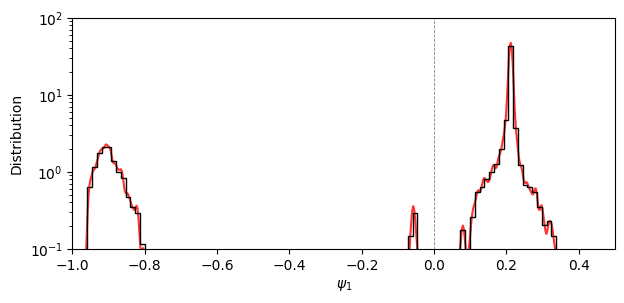

In [45]:
fig, ax = plt.subplots(figsize=(7, 3), dpi=100)
eigfun_idx = 0
mask = results['r_fun'][:, 0].real > -1
eigfun = results['r_fun'][:, eigfun_idx].real
pd.DataFrame(eigfun).plot.kde(ax=ax, color='r', logy=True, bw_method=0.01, legend=False, alpha=0.8)
ax.hist(eigfun,bins=100,histtype='step', color='k', density=True, )
ax.set_yscale('log')
ax.set_xlabel(r"$\psi_{" + str(eigfun_idx + 1) + r"}$")
ax.set_ylabel('Distribution')
ax.set_ylim(0.1, 100)
ax.set_xlim(-1, 0.5)
ax.axvline(x = 0, linestyle = '--', linewidth = 0.6, alpha = 0.5, color='k')

fig, ax = plt.subplots()
eigfun_idx = 1
mask = results['r_fun'][:, 0].real < 0 
eigfun = results['r_fun'][:, eigfun_idx].real
ax.hist(eigfun,bins=1000,histtype='step')
ax.set_yscale('log')
ax.set_xlabel(f'DeepTICA-{eigfun_idx + 1}')
ax.set_ylabel('Distribution')

## LASSO CLASSIFICATION

In [46]:
traj, desc_df, feats_info = descriptors("2JOF", sample_idxs=results['sample_idxs'], descriptors=['hbonds_contacts'])

In [47]:
from mlcolvar.data import DictDataset
df = desc_df.copy()

# Psi_1
eigfun_idx = 0
eigfun = results['r_fun'][:, eigfun_idx].real
mask = results['r_fun'][:, 0].real > -1
labels = np.zeros(len(df))
# State 1
labels[np.argwhere(np.logical_and(eigfun < 0, mask))] = 1
# State 2
labels[np.argwhere(np.logical_and(eigfun > 0, mask))] = 2

df['labels'] = labels
sel = (df['labels'] != 0 )

descr_type = 'distances' #'angles' #'distances' #'angles' 
stride = 20

if descr_type == 'angles':
    # get descriptors
    X = df[sel].filter(regex='phi|psi|xi|theta').values[::stride]
    feat_names = df[sel].filter(regex='phi|psi|xi|theta').columns.values

    # get labels
    y = df[sel]['labels'].values[::stride]

elif descr_type == 'distances':
    # get descriptors
    X = df[sel].filter(regex='HB').values[::stride]
    feat_names = df[sel].filter(regex='HB').columns.values

    # get labels
    y = df[sel]['labels'].values[::stride]

# create dataset
dataset = DictDataset(dict(data=X,labels=y))
dataset.feature_names = feat_names
dataset

DictDataset( "data": [131, 717], "labels": [131], "data_type": descriptors )

In [51]:
import warnings
from mlcolvar.explain.lasso import SparsityScoring, plot_lasso_classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import SelectFromModel
warnings.filterwarnings("ignore", category=FutureWarning)
def lasso_classification(dataset,
                         min_features = 0,
                         Cs = 40,
                         scale_inputs = True,
                         feature_names = None,
                         print_info = True,
                         plot = True
):
    """Perform sparse classification via LASSO on a given DictDataset (requires keys: "data" and "labels").
    The (inverse) regularization strength C is automatically chosen based on cross-validation on a set of values (Cs),
    see sklearn.linear_model.LogisticRegressionCV. The scoring function used is `SparsityScoring`, balancing the accuracy and the number of features.

    In the two-classes case a single classifier is built, otherwise a one-vs-rest classifier is constructed, composed by N different estimators are trained to classify each state from the others.
    
    Parameters
    ----------
    dataset : DictDataset
        dataset with 'data' and 'labels'
    min_features : int, optional
        minimum number of features, by default 0
    Cs : int or array-like, optional
        Each of the values in Cs describes the inverse of regularization strength. If Cs is as an int, then a grid of Cs values are chosen in a logarithmic scale between 1e-4 and 1e4. Like in support vector machines, smaller values specify stronger regularization., by default 40
    scale_inputs : bool, optional
        whether to standardize inputs based on mean and std.dev., by default True
    feature_names : list, optional
        names of the input features, if not given they are taken from `dataset.feature_names`, by default None
    print_info : bool, optional
        whether to print results, by default True
    plot : bool, optional
        whether to plot results, by default True

    See also
    --------
    mlcolvar.explain.lasso.SparsityScoring
        Scoring function used in LASSO classification

    Returns
    -------
    classifier: 
        optimized estimator
    feats: 
        dictionary with the names of the non-zero features, per label
    coeffs: 
        dictionary with the coefficients of the non-zero features, per label
    """

    # Convert dataset to numpy
    with torch.no_grad():
        raw_descriptors = dataset['data'].numpy()
        labels = dataset['labels'].numpy().astype(int)
    if feature_names is None:
        if dataset.feature_names is None:
            raise ValueError('Feature names not found (either in the dataset or as argument to the function).')
        feature_names = dataset.feature_names
    
    # Scaling inputs
    if scale_inputs:
        scaler = StandardScaler(with_mean=True, with_std=True)
        descriptors = scaler.fit_transform(raw_descriptors)
    else:
        descriptors = raw_descriptors

    # Define cross-validation for LASSO, using
    #   a custom scoring function based on accuracy and number of features
    scorer = SparsityScoring(min_features=min_features) 

    _classifier = LogisticRegressionCV(Cs=Cs, 
                                    solver='liblinear', 
                                    multi_class='ovr', 
                                    fit_intercept=False, 
                                    penalty='l1',
                                    n_jobs=20, 
                                    max_iter = 200,
                                    scoring=scorer)

    # Fit classifier
    feature_selector = SelectFromModel(_classifier)
    feature_selector.fit(descriptors, labels)

    classifier = feature_selector.estimator_

    # Get selected features and coefficients 
    feats = {}
    coeffs = {}

    for i,key in enumerate(classifier.coefs_paths_.keys()):

        index = np.abs(classifier.coef_).argsort()[i][::-1]

        sorted_feature_names = feature_names[index]
        sorted_coeffs = classifier.coef_[i,index]

        idx = np.argwhere ( np.abs(sorted_coeffs)>1e-5 )[:,0]
        selected_feature_names = sorted_feature_names[idx]
        selected_coeffs = sorted_coeffs[idx] 
        feats[key] = selected_feature_names
        coeffs[key] = selected_coeffs

        # display summary
        if print_info:
            #score = classifier.score(descriptors,labels)
            C_idx = np.argwhere(np.abs(classifier.Cs_ - classifier.C_[i]) < 1e-8)[0,0]
            score = classifier.scores_[key].mean(axis=0)[C_idx]
            accuracy = classifier.scoring.accuracy_from_score(score, len(selected_coeffs))

            print(f'======= LASSO results ({key}) ========')
            print(f'- Regularization : {classifier.C_[i]:.8f}')
            print(f'- Score          : {score:.2f}')
            print(f'- Accuracy       : {accuracy*100:.2f}%')
            print(f'- # features     : {len(selected_coeffs)}\n')
            print('Features: ')
            for j,(f,c) in enumerate(zip(selected_feature_names, selected_coeffs)):
                print(f'({j+1}) {f:13s}: {c:.6f}')
            print('==================================\n')

    # plot results
    if plot:
        plot_lasso_classification(classifier, feats, coeffs)

    return classifier, feats, coeffs

======= LASSO results (2) ========
- Regularization : 0.02811769
- Score          : -4.69
- Accuracy       : 97.31%
- # features     : 2

Features: 
(1) HB_C TRP6-NE1s -- PRO18-N: -0.370770
(2) HB_C TRP6-O -- GLY11-N: -0.009945



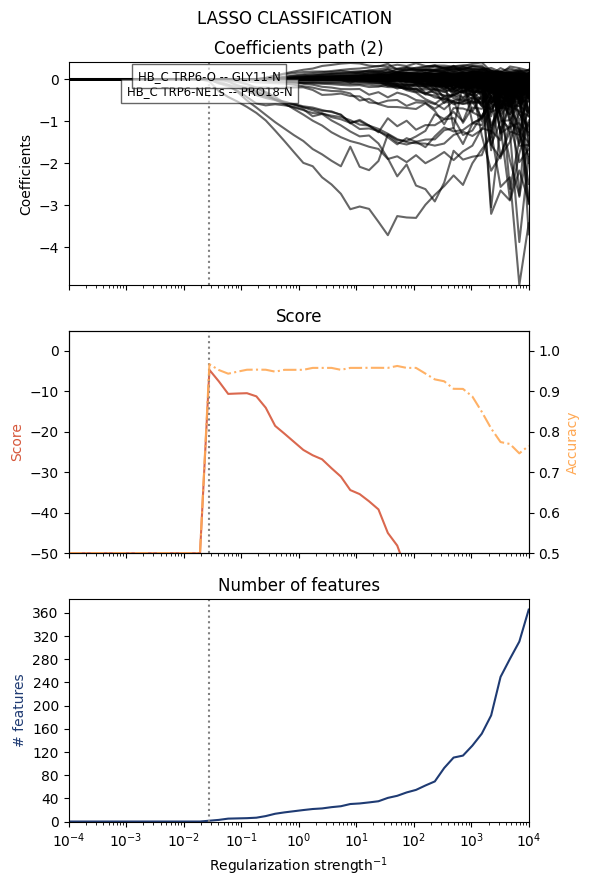

In [52]:
classifier, feats, coeffs = lasso_classification(dataset, Cs=50, plot=True)